In [1]:
import warnings
warnings.filterwarnings("ignore")

# Required Libraries

In [2]:

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow_text as tf_text
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Embedding, GlobalAveragePooling1D,LSTM, Flatten
from keras.utils import to_categorical
import string
from sklearn.preprocessing import OneHotEncoder
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import one_hot
import keras
from keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from gensim.models import Word2Vec
import gensim
import gensim.models as models
import turkishnlp
from turkishnlp import detector

# GPU CHECK

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [4]:

turkish_to_english = {
    "ı": "i",
    "İ": "I",
    "ö": "o",
    "Ö": "O",
    "ş": "s",
    "Ş": "S",
    "ğ": "g",
    "Ğ": "G",
    "ü": "u",
    "Ü": "U",
    "ç": "c",
    "Ç": "C",
}
def convert_turkish_to_english(text):
    for turkish, english in turkish_to_english.items():
        text = text.replace(turkish, english)
    return text


# Loading Data

In [5]:
data = pd.read_csv("data-not-duplicated-reviews.csv")
df = data.copy()
df["product-reviews"] = df["product-reviews"].astype('str')
df["product-category"] = df["product-category"].astype('str')
df['product-category'] = df['product-category'].apply(convert_turkish_to_english)
#df["product-reviews"] = df['product-reviews'].apply(convert_turkish_to_english)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81360 entries, 0 to 81359
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        81360 non-null  int64  
 1   product-id        81360 non-null  int64  
 2   product-name      81360 non-null  object 
 3   product-links     81360 non-null  object 
 4   product-category  81360 non-null  object 
 5   product-reviews   81360 non-null  object 
 6   product-rating    81360 non-null  float64
dtypes: float64(1), int64(2), object(4)
memory usage: 4.3+ MB


In [6]:
df.tail()

,Unnamed: 0,product-id,product-name,product-links,product-category,product-reviews,product-rating
81355,89604,544522950,Arzum AR684 Olivya 2400 W Buharlı Ütü,https://www.n11.com/urun/arzum-ar684-olivya-24...,Elektrikli Ev Aletleri,Hiç Arzum gibi değil alırsanız sizde anlayacak...,1.0
81356,89605,544522950,Arzum AR684 Olivya 2400 W Buharlı Ütü,https://www.n11.com/urun/arzum-ar684-olivya-24...,Elektrikli Ev Aletleri,Ürün sorunlu ve puroblemli,1.0
81357,89606,544522950,Arzum AR684 Olivya 2400 W Buharlı Ütü,https://www.n11.com/urun/arzum-ar684-olivya-24...,Elektrikli Ev Aletleri,iyi bir ürün beğendim sınıfında Ar 684 Arzum ü...,5.0
81358,89607,544522950,Arzum AR684 Olivya 2400 W Buharlı Ütü,https://www.n11.com/urun/arzum-ar684-olivya-24...,Elektrikli Ev Aletleri,Ürün güzel fakat firma rezalet. Ütünün arka ta...,1.0
81359,89608,544522950,Arzum AR684 Olivya 2400 W Buharlı Ütü,https://www.n11.com/urun/arzum-ar684-olivya-24...,Elektrikli Ev Aletleri,Fişe taktığımızdan itibaren çok hızlı bir şeki...,4.0


In [7]:
category_count = df["product-category"].value_counts()
categories = category_count.index
category_count

product-category
Evcil Hayvan Urunleri     34971
Elektrikli Ev Aletleri    19657
Agiz & Dis Bakimi         13602
Ayakkabi & Canta          13130
Name: count, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

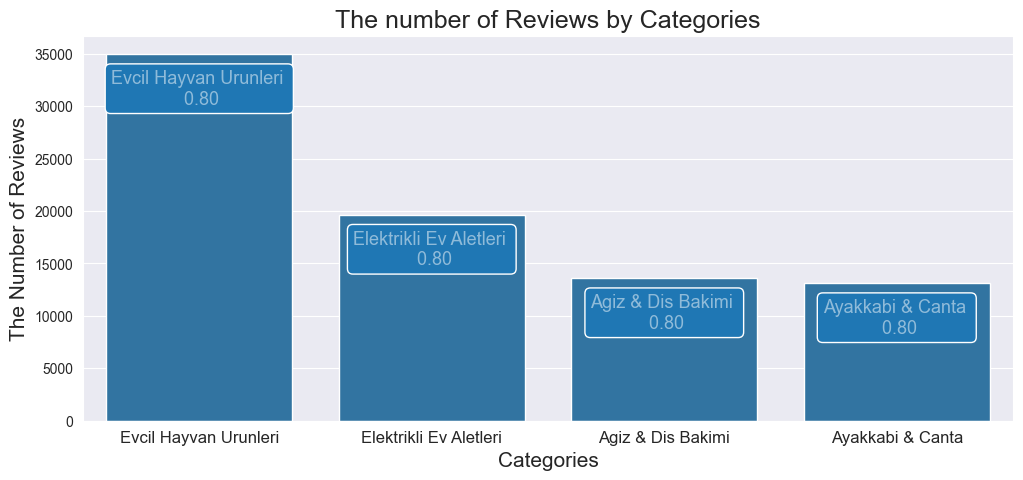

In [8]:
fig = plt.figure(figsize=(12,5))
ax= fig.add_subplot(111)
sns.barplot (x= categories, y=category_count)
for a,p in enumerate(ax.patches):
    ax.annotate(f'{categories[a]} \n '+format(p.get_width(), '.2f'), xy=(p.get_x() + p.get_width()/2.0, p.get_height()), xytext=(0,-25),size=13,color='white',ha='center',va='center',textcoords='offset points', bbox = dict(boxstyle='round'),alpha = 0.5)
plt.xlabel ("Categories",fontsize=15)
plt.ylabel ("The Number of Reviews",fontsize=15)
plt.xticks(size = 12)
plt.title("The number of Reviews by Categories",fontsize=18)
plt.show

# Encoding Categories

In [9]:

df["encoded-label"]= df["product-category"].astype('category').cat.codes
df["encoded-label"].value_counts()

data_texts = df["product-reviews"].to_list()

data_labels = df["encoded-label"].to_list()

df["encoded-label"].value_counts()

encoded-label
3    34971
2    19657
0    13602
1    13130
Name: count, dtype: int64

In [10]:
df["product-category"].value_counts()

product-category
Evcil Hayvan Urunleri     34971
Elektrikli Ev Aletleri    19657
Agiz & Dis Bakimi         13602
Ayakkabi & Canta          13130
Name: count, dtype: int64

# Train Test Splitting

In [11]:

train_texts,val_texts,train_labels,val_labels = train_test_split(data_texts, data_labels, test_size=0.2, random_state=42)

train_texts,test_texts,train_labels,test_labels = train_test_split(train_texts, train_labels, test_size=0.1, random_state=42)



# Tokenizing Words

In [12]:


tokenizer = Tokenizer(num_words=74771, oov_token="<UNK>")
tokenizer.fit_on_texts(data_texts)

tokenized_reviews = tokenizer.texts_to_sequences(data_texts)
word_index = tokenizer.word_index
print(word_index)
word_list = list(word_index.keys())

{'<UNK>': 1, 'ürün': 2, 'çok': 3, 'bir': 4, 've': 5, 'güzel': 6, 'için': 7, 'bu': 8, 'iyi': 9, 'ederim': 10, 'daha': 11, 'ama': 12, 'tavsiye': 13, 'kargo': 14, 'ürünü': 15, 'geldi': 16, 'gibi': 17, 'gayet': 18, 'teşekkürler': 19, 'de': 20, 'hızlı': 21, 'aldım': 22, 'kaliteli': 23, 'da': 24, 'mama': 25, 'severek': 26, 'yok': 27, 'teşekkür': 28, 'cok': 29, 'sokak': 30, 'ile': 31, 'uygun': 32, '2': 33, 'olarak': 34, 'memnun': 35, 'var': 36, 'fiyat': 37, 'beğendim': 38, 'her': 39, 'paketleme': 40, 'urun': 41, 'göre': 42, 'elime': 43, 'yiyor': 44, 'en': 45, 'değil': 46, 'kadar': 47, '1': 48, 'evet': 49, 'oldu': 50, 'sonra': 51, 'biraz': 52, 'gün': 53, 'ulaştı': 54, 'tam': 55, 'önce': 56, 'ben': 57, 'yiyorlar': 58, 'rahat': 59, 'şekilde': 60, 'kediler': 61, 'hiç': 62, 'sipariş': 63, 'kesinlikle': 64, 'harika': 65, '3': 66, 'mağaza': 67, 'sorun': 68, 'fakat': 69, 'aynı': 70, 'son': 71, 'kedim': 72, 'teslim': 73, 'ancak': 74, 'ne': 75, 'ediyorum': 76, 'kullanışlı': 77, 'su': 78, 'guzel': 79, '

In [13]:

train_sequences = tokenizer.texts_to_sequences(train_texts)
val_sequences = tokenizer.texts_to_sequences(val_texts)

print(train_sequences[11:15])
print(val_sequences[11:15])

arabad

[[2, 820, 5, 265, 304, 43, 54, 18, 77], [188, 2728, 1451], [21, 14, 4421, 242, 2832, 50, 4331, 852, 8736, 1950, 44707, 1082, 25477], [2, 398, 54, 525, 984, 91, 6747, 211, 65, 7938, 133, 13, 10]]
[[32, 471, 6996, 11339, 2344, 78, 27151, 8, 2858, 38, 12, 1290, 3, 4702, 631, 4515, 3414, 22, 52, 1040, 16, 48, 102, 134, 629, 252, 24, 13490, 7600, 92, 323, 4519, 5092, 216], [2, 3, 23, 11, 56, 20, 243, 12, 4556, 14, 613, 3, 5463, 2107, 88, 20421, 531, 11464, 4417, 11367, 5878, 121, 14, 613, 31, 5340], [9414, 882, 979, 15577, 8, 374, 130, 43916, 43917, 3, 2917, 8, 1432, 1358, 43918, 4, 67, 2393, 3, 477, 283, 437, 2637, 4, 25, 18558, 284, 25075, 780, 440, 87, 88, 667, 44, 40, 29, 136, 5, 4834, 2973, 590, 1878, 758, 50, 7430, 706, 1926, 853, 130, 746, 537, 10, 29, 357, 4, 43919, 9485, 153, 43920, 4, 560, 223, 14602, 10301, 861, 5, 502, 559, 573, 4, 5235, 43921, 43922, 201, 28, 273], [6, 478, 5, 246, 53, 949, 71, 23877, 20, 618, 3, 19]]


In [14]:
max_length  = 50
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding="post",truncating="post")
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding="post",truncating="post")
train_padded.shape,val_padded.shape

((58579, 50), (16272, 50))

In [15]:
print(train_texts[3125])
print(train_sequences[3125])
print(train_padded[3125])

Elime sorunsuz ulaştı.bence çok iyi
[43, 84, 54, 146, 3, 9]
[ 43  84  54 146   3   9   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


# Definition Of Model

In [16]:

model = keras.models.Sequential()
model.add(Embedding(input_dim = len(word_index)+1 , output_dim = 300 , input_length = max_length))
model.add(LSTM(256,return_sequences = True))
model.add(LSTM(256,return_sequences = True))
model.add(LSTM(256))
model.add(Dense(4, activation = "softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 300)           22831500  
                                                                 
 lstm (LSTM)                 (None, 50, 256)           570368    
                                                                 
 lstm_1 (LSTM)               (None, 50, 256)           525312    
                                                                 
 lstm_2 (LSTM)               (None, 256)               525312    
                                                                 
 dense (Dense)               (None, 4)                 1028      
                                                                 
Total params: 24,453,520
Trainable params: 24,453,520
Non-trainable params: 0
_________________________________________________________________


In [17]:
checkpoint_filepath = "best_model.h5"
checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor="val_loss",
    save_best_only=True,
    mode='min' 
)

In [18]:
model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics="accuracy")

In [19]:
train_labels = pd.Series(train_labels)
val_labels = pd.Series(val_labels)
model.fit(train_padded,train_labels,epochs=20,validation_data=(val_padded, val_labels), callbacks=[checkpoint])


Epoch 1/20
1831/1831 [==============================] - 62s 29ms/step - loss: 1.1753 - accuracy: 0.5071 - val_loss: 1.1432 - val_accuracy: 0.5417
Epoch 2/20
1831/1831 [==============================] - 52s 28ms/step - loss: 0.8626 - accuracy: 0.6092 - val_loss: 0.7510 - val_accuracy: 0.6599
Epoch 3/20
1831/1831 [==============================] - 51s 28ms/step - loss: 0.6391 - accuracy: 0.7167 - val_loss: 0.6832 - val_accuracy: 0.7071
Epoch 4/20
1831/1831 [==============================] - 55s 30ms/step - loss: 0.5024 - accuracy: 0.7887 - val_loss: 0.6370 - val_accuracy: 0.7349
Epoch 5/20
1831/1831 [==============================] - 58s 31ms/step - loss: 0.4141 - accuracy: 0.8292 - val_loss: 0.6859 - val_accuracy: 0.7302
Epoch 6/20
1831/1831 [==============================] - 55s 30ms/step - loss: 0.3564 - accuracy: 0.8523 - val_loss: 0.7740 - val_accuracy: 0.7310
Epoch 7/20
1831/1831 [==============================] - 55s 30ms/step - loss: 0.3229 - accuracy: 0.8631 - val_loss: 0.7778 -

# Application of Model

In [20]:
def apply_model (text):
    text = tokenizer.texts_to_sequences([text])
    text = pad_sequences(text,maxlen=max_length)
    y_pred = model.predict(text)
    y_pred = np.argmax(y_pred)
    return y_pred

In [21]:
new_sentence = "43 numara istemiştim 44 geldi"
predicted_sentiment = apply_model(new_sentence)
if predicted_sentiment == 0:
    predicted_sentiment = "Ağız ve diş"
elif predicted_sentiment == 1 :
    predicted_sentiment = "ayakkabı çanta"
elif predicted_sentiment ==2:
    predicted_sentiment= 'Elektrikli Ev aleti'
elif predicted_sentiment == 3:
    predicted_sentiment = "evcil hayvan"

print("Tahmin edilen kategori:", predicted_sentiment)

1/1 [==============================] - 1s 947ms/step
Tahmin edilen kategori: ayakkabı çanta


# Word2Vec

In [22]:
review_text=df["product-reviews"].apply(gensim.utils.simple_preprocess)
review_text

0                   [ürün, guzel, kediler, severek, yiyor]
1        [evdeki, ve, sokaktaki, kediler, için, alıyoru...
2                                 [severek, yediğim, mama]
3               [çok, severek, yiyorlar, ve, hızlı, geldi]
4        [devamlı, aldığım, marka, çok, memnunum, tavsi...
                               ...                        
81355    [hiç, arzum, gibi, değil, alırsanız, sizde, an...
81356                      [ürün, sorunlu, ve, puroblemli]
81357    [iyi, bir, ürün, beğendim, sınıfında, ar, arzu...
81358    [ürün, güzel, fakat, firma, rezalet, ütünün, a...
81359    [fişe, taktığımızdan, itibaren, çok, hızlı, bi...
Name: product-reviews, Length: 81360, dtype: object

In [39]:
model = Word2Vec(
    sentences=review_text,
    window=5,
    min_count=3,
    workers = 14,
    )


In [40]:
model.build_vocab(review_text, progress_per=1000)


In [41]:
model.epochs

5

In [42]:
model.train(review_text, total_examples=model.corpus_count, epochs=model.epochs)

(4492200, 5624515)

In [43]:
model.save("word2vec.model")

In [52]:
a = str(input("Enter a word "))
convert_turkish_to_english(a)
type(a)

str

In [54]:
try:
    print(model.wv.most_similar(a))
except KeyError:
    a = str(input("Enter another word"))
    print(model.wv.most_similar(a))


[('teşekkürleer', 0.8889563083648682), ('arıtmak', 0.8883549571037292), ('videosundaki', 0.8781079649925232), ('degerini', 0.8765033483505249), ('bastırması', 0.8743081092834473), ('müstakil', 0.8742318153381348), ('toka', 0.8729540705680847), ('beraberinde', 0.8728410005569458), ('gaz', 0.8716902732849121), ('ortalıkta', 0.8712888956069946)]


# Word Embedding

In [30]:
vocab_size=len(word_index)
encoded_reviews = [one_hot(d, vocab_size) for d in data_texts]
print(encoded_reviews[1])

[68055, 32030, 42364, 52486, 24635, 71520, 7986, 11366, 21878, 11233, 19462, 37848, 41264, 2824, 12003, 2074, 7198, 51870, 16440]


In [31]:
padded_reviews = pad_sequences(encoded_reviews, maxlen=max_length,padding="post")
padded_reviews

array([[31756, 23915, 52486, ...,     0,     0,     0],
       [68055, 32030, 42364, ...,     0,     0,     0],
       [11366, 63957,  7562, ...,     0,     0,     0],
       ...,
       [71985, 75054, 31756, ...,     0,     0,     0],
       [31756, 65678, 74460, ...,     0,     0,     0],
       [40179, 75517,  8704, ...,     0,     0,     0]])

In [32]:
embdeded_vector_size=30
model = Sequential()
model.add(Embedding(vocab_size,embdeded_vector_size,input_length=max_length,name="embedding"))
model.add(Flatten())
model.add(Dense(3,activation="sigmoid"))

In [33]:
model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])
model.summary()
labels = df["encoded-label"].to_numpy()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 30)            2283120   
                                                                 
 flatten (Flatten)           (None, 1500)              0         
                                                                 
 dense_1 (Dense)             (None, 3)                 4503      
                                                                 
Total params: 2,287,623
Trainable params: 2,287,623
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.fit(padded_reviews,labels,epochs=5,verbose=0)

In [35]:
loss, accuracy = model.evaluate(padded_reviews,labels)

2543/2543 [==============================] - 4s 2ms/step - loss: nan - accuracy: 0.1672


In [36]:
weights= model.get_layer("embedding").get_weights()[0]
weights

array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [-0.01820445,  0.01924601, -0.04410798, ...,  0.01636276,
         0.0347528 ,  0.03626206],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]], dtype=float32)

In [37]:
data_texts[1]

'Evdeki ve sokaktaki kediler için alıyorum.Hepsi severek yiyorlar.Kdv sorunu çözülmesi lazım , sonuçta hayvan mamaları lüks tüketim değildir..'

# Word Bugging
